In [1]:
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [2]:
images_path = Path('data/CatsDogs/images')
anno_path = Path('data/CatsDogs/annotations')

In [3]:
def filelist(root, file_type):
    """Функция возвращает полностью квалифицированный список файлов в директории"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [4]:
df_train = generate_train_df(anno_path)

In [5]:
df_train.head(2)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,data\CatsDogs\images\Cats_Test0.png,233,350,cat,83,29,197,142
1,data\CatsDogs\images\Cats_Test1.png,500,500,dog,128,22,240,222


Преобразуем наши метки в классы:

In [6]:
class_dict = {'dog': 0, 'cat': 1}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

In [7]:
print(df_train.shape)
df_train.head()

(3686, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,data\CatsDogs\images\Cats_Test0.png,233,350,1,83,29,197,142
1,data\CatsDogs\images\Cats_Test1.png,500,500,0,128,22,240,222
2,data\CatsDogs\images\Cats_Test10.png,500,375,0,157,56,264,116
3,data\CatsDogs\images\Cats_Test100.png,500,375,1,142,145,206,209
4,data\CatsDogs\images\Cats_Test1000.png,335,500,1,36,14,289,312


### Изменение размеров изображений и обрамляющих прямоугольников

In [8]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [9]:
def create_mask(bb, x):
    """Создаем маску для обрамляющего прямоугольника такого же шейпа как и изображение"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Конвертируем маску Y в обрамляющий прямоугольник, принимая 0 как фоновый ненулевой объект """
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Генерируем массив обрамляющих прямоугольников из столбца train_df"""
    return np.array([x[5],x[4],x[7],x[6]])

In [10]:
def resize_image_bb(read_path,write_path,bb,sz):
    """Ресайзим изображение и его обрамляющий прямоугольник и записываем изображение в новый путь"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [11]:
new_paths = []
new_bbs = []
train_path_resized = Path('data/CatsDogs/images_resized')
for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values),300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

In [12]:
df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
0,data\CatsDogs\images\Cats_Test0.png,233,350,1,83,29,197,142,data\CatsDogs\images_resized\Cats_Test0.png,"[24.0, 158.0, 121.0, 378.0]"
1,data\CatsDogs\images\Cats_Test1.png,500,500,0,128,22,240,222,data\CatsDogs\images_resized\Cats_Test1.png,"[13.0, 114.0, 132.0, 214.0]"
2,data\CatsDogs\images\Cats_Test10.png,500,375,0,157,56,264,116,data\CatsDogs\images_resized\Cats_Test10.png,"[44.0, 140.0, 92.0, 235.0]"
3,data\CatsDogs\images\Cats_Test100.png,500,375,1,142,145,206,209,data\CatsDogs\images_resized\Cats_Test100.png,"[116.0, 127.0, 167.0, 184.0]"
4,data\CatsDogs\images\Cats_Test1000.png,335,500,1,36,14,289,312,data\CatsDogs\images_resized\Cats_Test1000.png,"[8.0, 47.0, 186.0, 385.0]"


### Пример получившегося сэмпла

In [13]:
im = cv2.imread(str(df_train.values[58][0]))
bb = create_bb_array(df_train.values[58])
print(im.shape)

(281, 500, 3)


In [14]:
Y = create_mask(bb, im)
mask_to_bb(Y)

array([ 46., 205., 114., 276.], dtype=float32)

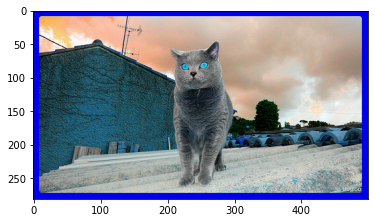

In [15]:
plt.imshow(im)

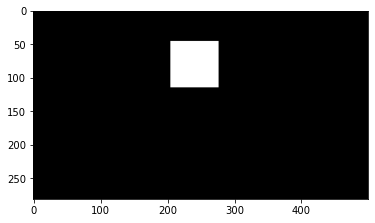

In [16]:
plt.imshow(Y, cmap='gray')

### Аугментация данных

In [17]:
# Вырезаем кусок с изображения
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# Случайное вырезание части картинки
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

# Центральное вырезание 
def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

In [18]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Поворачиваем наше изображение"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Возвращает случайное вырезание"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

# Трансформируем нашу картинку 
def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [19]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

### Пример изображения 

Оригинал:

data\CatsDogs\images_resized\Cats_Test1013.png


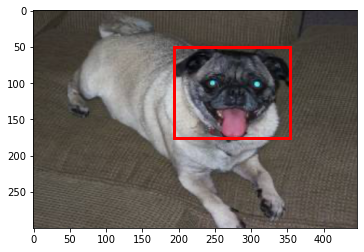

In [20]:
number = 18
im = cv2.imread(str(df_train.values[number][8]))
print(str(df_train.values[number][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train.values[number][9])

После трансформации:

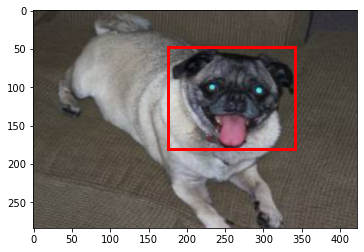

In [21]:
im, bb = transformsXY(str(df_train.values[number][8]),df_train.values[number][9],True )
show_corner_bb(im, bb)

### Датасет

In [22]:
df_train = df_train.reset_index()
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [23]:
def normalize(im):
    """Нормализация данных с помощью статистики ImageNet"""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [24]:
class CatsDogs(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [25]:
train_ds = CatsDogs(X_train['new_path'],X_train['new_bb'] ,y_train, transforms=True)
valid_ds = CatsDogs(X_val['new_path'],X_val['new_bb'],y_val)

In [26]:
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

### Определение модели

In [27]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 2))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

### Обучение

In [28]:
model = BB_model().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)
epochs = 15


In [29]:
for i in range(epochs):
    
    model.train()
    total = 0
    sum_loss = 0
    C=1000
    
    for x, y_class, y_bb in train_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
#         print(y_bb.shape)
#         print(y_class.shape)
        out_class, out_bb = model(x)
#         print(out_bb.shape)
#         print(out_class.shape)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total += batch
        sum_loss += loss.item()
    train_loss = sum_loss/total
    
    # Eval
    model.eval()
    val_total = 0
    val_sum_loss = 0
    correct = 0
    
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")

        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        val_sum_loss += loss.item()
        val_total += batch
    val_loss = val_sum_loss/val_total
    val_acc = correct/val_total
    
    print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))

train_loss 1.116 val_loss 1.274 val_acc 0.607
train_loss 0.924 val_loss 0.935 val_acc 0.657
train_loss 0.934 val_loss 0.887 val_acc 0.656
train_loss 0.832 val_loss 26.609 val_acc 0.599
train_loss 0.855 val_loss 0.824 val_acc 0.656
train_loss 0.841 val_loss 0.940 val_acc 0.667
train_loss 0.858 val_loss 1.036 val_acc 0.661
train_loss 0.810 val_loss 0.797 val_acc 0.663
train_loss 0.807 val_loss 1.665 val_acc 0.668
train_loss 0.797 val_loss 0.836 val_acc 0.664
train_loss 0.790 val_loss 0.811 val_acc 0.682
train_loss 0.779 val_loss 0.781 val_acc 0.675
train_loss 0.780 val_loss 0.794 val_acc 0.660
train_loss 0.776 val_loss 0.810 val_acc 0.664
train_loss 0.772 val_loss 0.779 val_acc 0.675


In [38]:
for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = 0.001

In [39]:
for i in range(epochs):
    
    model.train()
    total = 0
    sum_loss = 0
    C=1000
    
    for x, y_class, y_bb in train_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total += batch
        sum_loss += loss.item()
    train_loss = sum_loss/total
    
    # Eval
    model.eval()
    val_total = 0
    val_sum_loss = 0
    correct = 0
    
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
#         print(out_bb.shape)
#         print(out_bb.shape)
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        val_sum_loss += loss.item()
        val_total += batch
    val_loss = val_sum_loss/val_total
    val_acc = correct/val_total
    
    print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))

train_loss 0.757 val_loss 0.758 val_acc 0.690
train_loss 0.746 val_loss 0.778 val_acc 0.694
train_loss 0.739 val_loss 0.759 val_acc 0.698
train_loss 0.731 val_loss 0.739 val_acc 0.715
train_loss 0.721 val_loss 0.727 val_acc 0.728
train_loss 0.715 val_loss 0.770 val_acc 0.691
train_loss 0.706 val_loss 0.720 val_acc 0.734
train_loss 0.695 val_loss 0.741 val_acc 0.713
train_loss 0.680 val_loss 0.737 val_acc 0.710
train_loss 0.669 val_loss 0.721 val_acc 0.736
train_loss 0.660 val_loss 0.731 val_acc 0.692
train_loss 0.646 val_loss 0.686 val_acc 0.747
train_loss 0.642 val_loss 0.673 val_acc 0.756
train_loss 0.621 val_loss 0.639 val_acc 0.776
train_loss 0.603 val_loss 0.623 val_acc 0.780


# Тестирование

In [52]:
# resizing test image
im_num = 331
im = read_image(f'data/CatsDogs/images_resized/Cats_Test{im_num}.png')
im = cv2.resize(im, (int(1.49*300), 300))
cv2.imwrite(f'data/CatsDogs/catsdogs_test/Cats_Test{im_num}.jpg', cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

True

In [53]:
# test Dataset
test_ds = CatsDogs(pd.DataFrame([{'path':f'data/CatsDogs/catsdogs_test/Cats_Test{im_num}.jpg'}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],pd.DataFrame([{'y':[0]}])['y'])
x, y_class, y_bb = test_ds[0]

In [54]:
xx = torch.FloatTensor(x[None,])
xx.shape

torch.Size([1, 3, 284, 423])

In [55]:
# prediction
out_class, out_bb = model(xx.cuda())
out_class, out_bb

(tensor([[-0.2817,  0.3410]], device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[ 24.6767, 109.9770, 147.8361, 264.5179]], device='cuda:0',
        grad_fn=<AddmmBackward>))

In [56]:
# predicted class
torch.max(out_class, 1)

torch.return_types.max(
values=tensor([0.3410], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([1], device='cuda:0'))

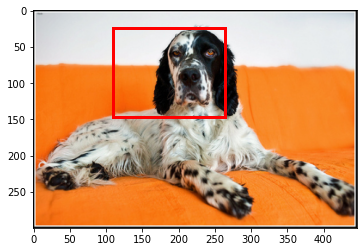

In [57]:
# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])

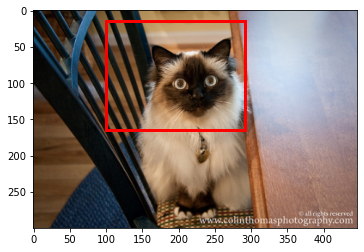

In [51]:
# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])